In [1]:
# Step 1

import pandas as pd
import numpy as np
from gurobipy import Model, GRB, quicksum

df = pd.read_csv("data/data.csv")

# Extracting name column into a list
I = df["name"].tolist()

# Time slots with slot size 0.5 representing 30 minutes
slot_size = 0.5
T = np.arange(0, 24 + slot_size, slot_size).tolist()

# Create a dictonary mapping each student to the earliest time that they can start laundry
start_time = {}
for _, row in df.iterrows():
    start_time[row["name"]] = row["start_time"]

# To start initialize every student to have an empty dictionary, 
# then loop through each students row looking for their start time and end time. 
# Through the for loop fill each students row by seeing if t (time) is inside their window
availability = {i: {} for i in I}
for _, row in df.iterrows():
    name = row["name"]
    start = row["start_time"]
    end = row["end_time"]
    for t in T:
        availability[name][t] = 1 if start <= t <= end else 0

# Washer and dryer names used for the model
washers = ["W1","W2","W3","W4"]
dryers = ["D1","D2","D3","D4"]

In [2]:
# Step 2

# Initialize a Gurobi model which will contain everything
m = Model("LaundryScheduling")

Set parameter Username
Set parameter LicenseID to value 2702124
Academic license - for non-commercial use only - expires 2026-09-02


In [3]:
# Step 3 (Decision variables)

# W[i, j, t] = 1  -> student i is assigned to wash on machine j at time t
# W[i, j, t] = 0  -> otherwise
# Goal is to loop over all of the students, washing machines, and time slots and create every possible choice so that the optimizer
# can choose the best combo for each student 
W = {}
for i in I:
    for j in washers:
        for t in T:
            W[i,j,t] = m.addVar(vtype=GRB.BINARY, name=f"W[{i},{j},{t}]")

# D[i, j, t] = 1  -> student i is assigned to use dryer j at time t
# D[i, j, t] = 0  -> otherwise
# Goal is to loop over all of the students, dryers, and time slots and create every possible choice so that the optimizer
# can choose the best combo for each student 
D = {}
for i in I:
    for j in dryers:
        for t in T:
            D[i,j,t] = m.addVar(vtype=GRB.BINARY, name=f"D[{i},{j},{t}]")

# Delay is used to measure how long it takes for a student has to wait to get a washer also enforce fairness
delay = {}
for i in I:
    delay[i] = m.addVar(vtype=GRB.CONTINUOUS, name=f"delay[{i}]")

In [4]:
# Step 4 (Assigned Times)

# Assigned wash and dry times for each student
assigned_time = {}
assigned_dry_time = {}

# For both the quicksum picks out the single time W[i,j,t] = 1 and D[i,j,t] = 1 and that becomes the 
# students assigned wash and dry time
for i in I:
    assigned_time[i] = quicksum(t * W[i,j,t] for j in washers for t in T)
    assigned_dry_time[i] = quicksum(t * D[i,j,t] for j in dryers for t in T)

In [5]:
# Step 5 (Constraints)

# Each student gets exactly 1 wash and 1 dry slot
for i in I:
    m.addConstr(quicksum(W[i,j,t] for j in washers for t in T) == 1, name=f"OneWash[{i}]")
    m.addConstr(quicksum(D[i,j,t] for j in dryers  for t in T) == 1, name=f"OneDry[{i}]")

# At most one student can use a washer and dryer at the same time
for j in washers:
    for t in T:
        m.addConstr(quicksum(W[i,j,t] for i in I) <= 1, name=f"WasherCap[{j},{t}]")

for j in dryers:
    for t in T:
        m.addConstr(quicksum(D[i,j,t] for i in I) <= 1, name=f"DryerCap[{j},{t}]")

# If a student isn't available at t (time) then the cannot wash or dry at t
for i in I:
    for t in T:
        if availability[i][t] == 0:
            m.addConstr(quicksum(W[i,j,t] for j in washers) == 0, name=f"NoWash[{i},{t}]")
            m.addConstr(quicksum(D[i,j,t] for j in dryers) == 0, name=f"NoDry[{i},{t}]")

# Drying must occur after washing
for i in I:
    m.addConstr(assigned_dry_time[i] >= assigned_time[i] + 0.5, name=f"DryAfterWash[{i}]")

# Drying must occur within 30 minutes of washing ending
for i in I:
    m.addConstr(assigned_dry_time[i] - assigned_time[i] <= 1, name=f"DryWithin30MinofWash[{i}]")

# A student cannot wash and dry at the same time slot
for i in I:
    for t in T:
        for j_w in washers:
            for j_d in dryers:
                m.addConstr(D[i,j_d,t] + W[i,j_w,t] <= 1, name=f"NoSameSlot[{i},{t},{j_w},{j_d}]")

# Calculates how far the students actual wash time is from their preferred start wash time
for i in I:
    m.addConstr(delay[i] >= assigned_time[i] - start_time[i], name=f"DelayDef1[{i}]")
    m.addConstr(delay[i] >= 0, name=f"DelayNonNeg[{i}]")

In [6]:
# Step 6 (Objective function)
objective = quicksum(delay[i] for i in delay)
m.setObjective(objective, GRB.MINIMIZE)

# Step 7 (Gurobi solver)

m.optimize()


# Step 8 (Print schedule)

if m.status == GRB.OPTIMAL:
    print("\nLaundry Schedule:")
    print("Student | WashMachine | WashTime | DryMachine | DryTime | Delay")
    print("--------+------------+----------+-----------+---------+-------")

    for i in I:
        
        wash_assign = [(j,t) for j in washers for t in T if W[i,j,t].x > 0.5]
        dry_assign  = [(j,t) for j in dryers  for t in T if D[i,j,t].x > 0.5]

        if wash_assign:
            w_j, w_t = wash_assign[0]
        else:
            w_j, w_t = None, None

        if dry_assign:
            d_j, d_t = dry_assign[0]
        else:
            d_j, d_t = None, None

        print(f"{i:8} | {w_j:10} | {w_t:8} | {d_j:9} | {d_t:7} | {delay[i].x:5.2f}")

# Step 9 (Print schedule to csv)
import csv

# Write schedule results to a CSV file
with open("data/results.csv", "w", newline="") as f:
    writer = csv.writer(f)
    
    # Header row
    writer.writerow(["Student", "WashMachine", "WashTime", "DryMachine", "DryTime", "Delay"])
    
    # Data rows
    for i in I:
        wash_assign = [(j,t) for j in washers for t in T if W[i,j,t].x > 0.5]
        dry_assign  = [(j,t) for j in dryers  for t in T if D[i,j,t].x > 0.5]

        if wash_assign:
            w_j, w_t = wash_assign[0]
        else:
            w_j, w_t = None, None

        if dry_assign:
            d_j, d_t = dry_assign[0]
        else:
            d_j, d_t = None, None

        writer.writerow([i, w_j, w_t, d_j, d_t, round(delay[i].x, 1)])



Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 48154 rows, 21615 columns and 199518 nonzeros
Model fingerprint: 0xa9e28dbe
Variable types: 55 continuous, 21560 integer (21560 binary)
Coefficient statistics:
  Matrix range     [5e-01, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-01, 2e+01]
Presolve removed 47241 rows and 17756 columns
Presolve time: 0.06s
Presolved: 913 rows, 3859 columns, 17770 nonzeros
Variable types: 0 continuous, 3859 integer (3859 binary)
Found heuristic solution: objective 70.0000000

Root relaxation: objective 1.950000e+01, 446 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                      19.5

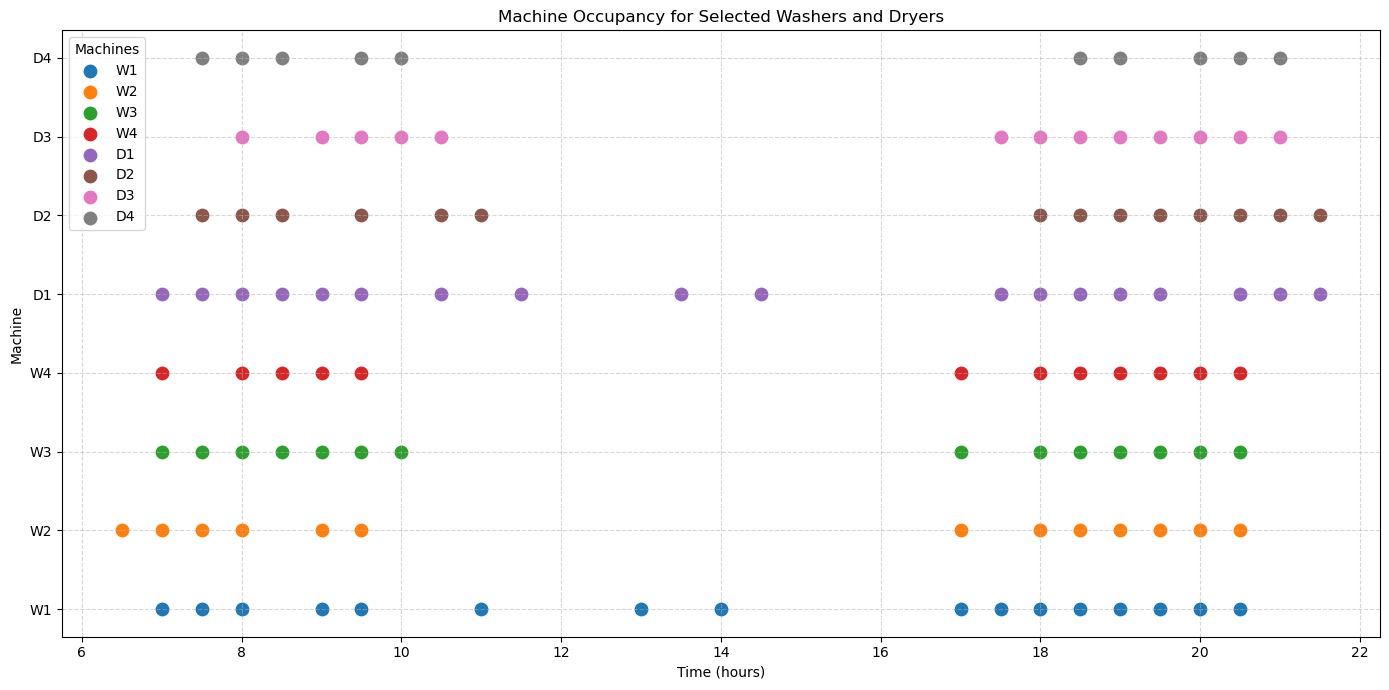

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("data/results.csv")

machine_data = {}

for machine in washers + dryers:
    if machine.startswith("W"):  
        times = df[df["WashMachine"] == machine]["WashTime"]
    else:  
        times = df[df["DryMachine"] == machine]["DryTime"]
    machine_data[machine] = times.tolist()

plt.figure(figsize=(14, 7))

for machine, times in machine_data.items():
    plt.scatter(times, [machine] * len(times), s=80, label=machine)

plt.xlabel("Time (hours)")
plt.ylabel("Machine")
plt.title("Machine Occupancy for Selected Washers and Dryers")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Machines")
plt.tight_layout()

plt.show()
